In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FixedLocator, MultipleLocator
from scipy import optimize
from scipy.signal import argrelextrema

%matplotlib inline

1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

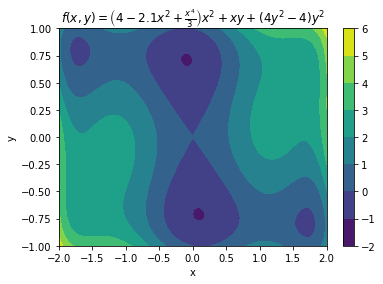

In [2]:
# First we visualize the function to have an idea of the minima locations
def f(x):
  return (4-2.1*x[0]**2+(1/3)*x[0]**4)*x[0]**2 + x[0]*x[1] + (4*x[1]**2-4)*x[1]**2

x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
Z = f([X, Y])

plt.contourf(X, Y, Z)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$')
plt.show()

FIRST GLOBAL MINIMUM COORDINATES:
The first minimum is at position (0.0898,-0.7127), where the function gets value -1.0316

SECOND GLOBAL MINIMUM:
The second minimum is at position (-0.0898,0.7127), where the function gets value -1.0316


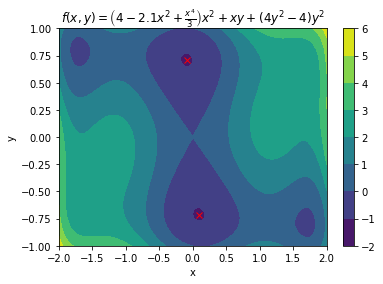

In [7]:
print("FIRST GLOBAL MINIMUM COORDINATES:")
# starting point for first global minimum
x01 = [0, -0.5]
x_min_1 = optimize.minimize(f, x01, method='BFGS')
print("The first minimum is at position ({:.4f},{:.4f}), where the function gets value {:.4f}"
    .format(x_min_1.x[0], x_min_1.x[1], x_min_1.fun))

print("\nSECOND GLOBAL MINIMUM:")

# starting point for second global minimum
x02 = [0, 0.5]
x_min_2 = optimize.minimize(f, x02, method='BFGS')
print("The second minimum is at position ({:.4f},{:.4f}), where the function gets value {:.4f}"
    .format(x_min_2.x[0], x_min_2.x[1], x_min_2.fun))

plt.contourf(X, Y, Z)
plt.plot(x_min_1.x[0], x_min_1.x[1], 'xr')
plt.plot(x_min_2.x[0], x_min_2.x[1], 'xr')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$')
plt.show()

In [8]:
# (0, 0) as starting point
x0 = [0, 0]
x_min = optimize.minimize(f, x0)
print("The minimum is found at position ({:.2f},{:.2f}), where the function gets value {:.2f}"
    .format(x_min.x[0], x_min.x[1], x_min.fun))

print("We may say that the minimization stucks in a local minima if we choose (0, 0) as starting point")

The minimum is found at position (0.00,0.00), where the function gets value 0.00
We may say that the minimization stucks in a local minima if we choose (0, 0) as starting point


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

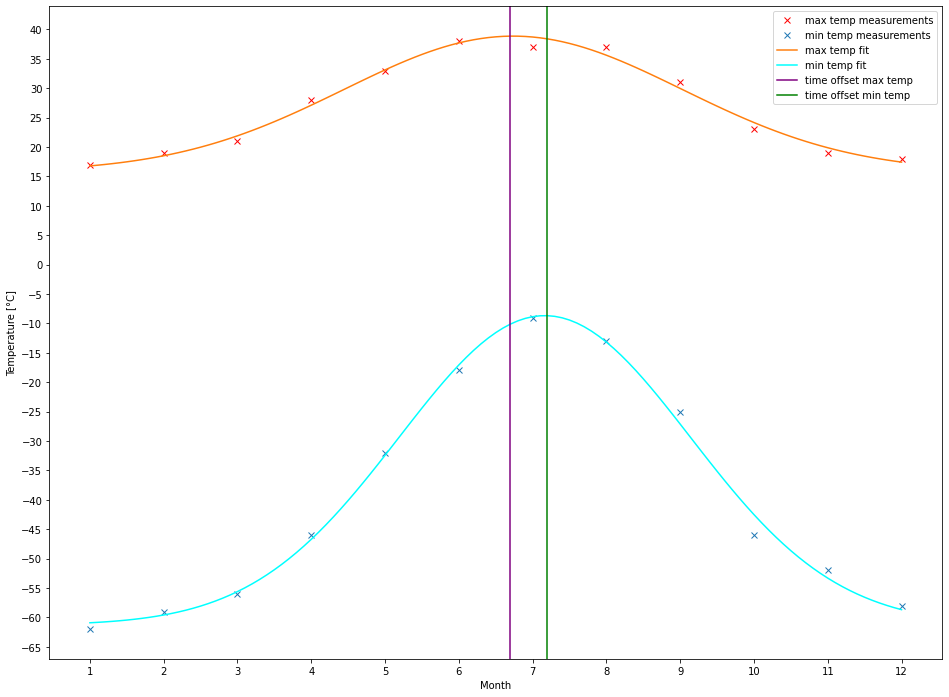

In [17]:
temp_max = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
temp_min = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
months = np.arange(1, 13)

fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(months, temp_max, 'x', color='red', label='max temp measurements')
ax.plot(months, temp_min, 'x', label='min temp measurements')
ax.xaxis.set_major_locator(FixedLocator(range(13)))
ax.yaxis.set_major_locator(MultipleLocator(5))

def gauss_function(x, a, mu, sigma, c):
    return a*np.exp(-(x-mu)**2/(2*sigma**2)) + c

popt_max, pcov = optimize.curve_fit(gauss_function, months, temp_max)
popt_min, pcov = optimize.curve_fit(gauss_function, months, temp_min)

months_high_res = np.arange(1, 12.1, 0.1)

temp_max_fit = gauss_function(months_high_res, popt_max[0], popt_max[1], popt_max[2], popt_max[3])
temp_min_fit = gauss_function(months_high_res, popt_min[0], popt_min[1], popt_min[2], popt_min[3])

ax.plot(months_high_res, temp_max_fit, label='max temp fit')
ax.plot(months_high_res, temp_min_fit, color='aqua', label='min temp fit')

ax.axvline(months_high_res[np.argmax(temp_max_fit)], color='purple', label='time offset max temp')
ax.axvline(months_high_res[np.argmax(temp_min_fit)], color='green', label='time offset min temp')

ax.set_xlabel('Month')
ax.set_ylabel('Temperature [°C]')

#ax.set_xticklabels(['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])

ax.legend()

The fit seems good for both the sets of measurements, capturing the seasonality of the trends. However, the time offset fot min and max temperatures differs:

In [142]:
print("Max temperature time offset -> {:.3f}".format(months_high_res[np.argmax(temp_max_fit)]))
print("Min temperature time offset -> {:.3f}".format(months_high_res[np.argmax(temp_min_fit)]))

Max temperature time offset -> 6.700
Min temperature time offset -> 7.200


3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

Text(0, 0.5, 'Counts')

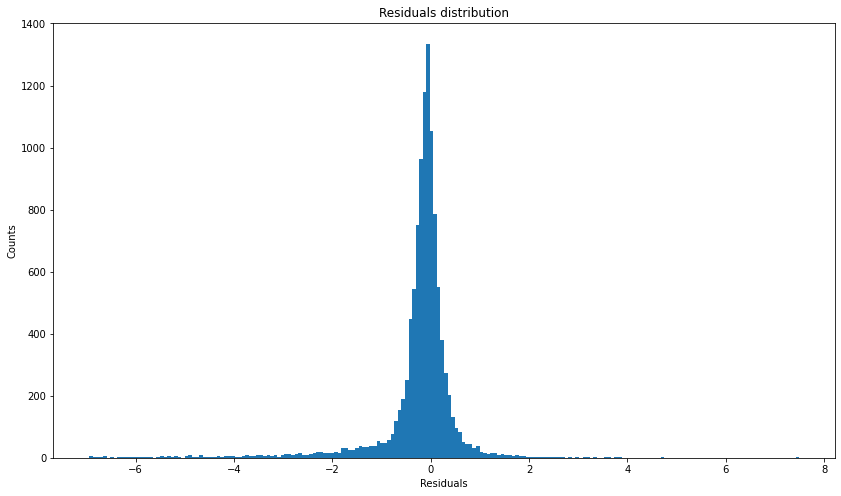

In [181]:
path = "data/residuals_261.pkl"
pickle_data = np.array(np.load(path, allow_pickle=True), ndmin=1)
data = pickle_data[0]

df = pd.DataFrame(data=data, columns=['residuals', 'distances'])
df = df[(df['residuals'] > -7) & (df['residuals'] < 8)]
df_res = pd.DataFrame(df['residuals'])

fig, ax = plt.subplots(figsize=(14, 8))
h, bins, _ = plt.hist(df_res, bins=200)
ax.set_title('Residuals distribution')
ax.set_xlabel('Residuals')
ax.set_ylabel('Counts')

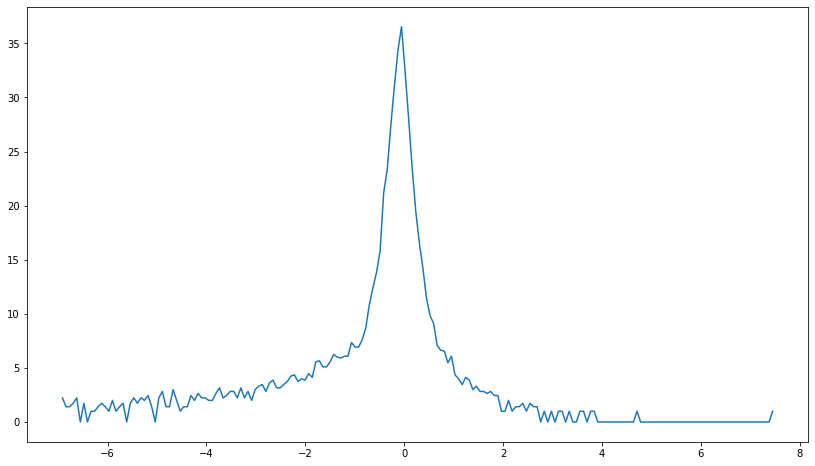

In [189]:
centers = (bins[1:]+bins[:-1])/2
err_h = np.sqrt(h)

fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(centers, err_h)

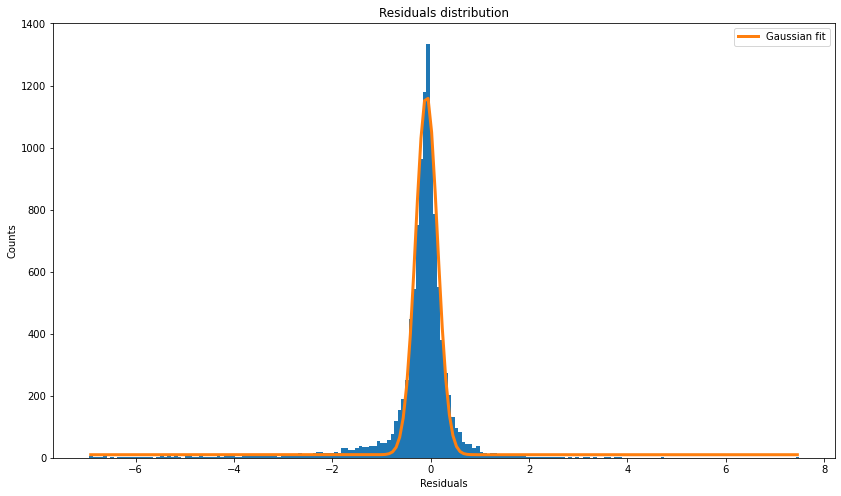

In [194]:
def gauss_function(x, a, mu, sigma, c):
    return a*np.exp(-(x-mu)**2/(2*sigma**2)) + c

popt, pcov = optimize.curve_fit(gauss_function, centers, h)

fig, ax = plt.subplots(figsize=(14, 8))
ax.hist(df_res, bins=200)
ax.plot(centers, gauss_function(centers, popt[0], popt[1], popt[2], popt[3]), linewidth=3, label='Gaussian fit')
ax.set_title('Residuals distribution')
ax.set_xlabel('Residuals')
ax.set_ylabel('Counts')
ax.legend()

In [207]:
import scipy

ndof = len(centers) - 1
print("n degrees of freedom =", ndof)
# calculate the chi^2
err_h[err_h == 0] = 1
chi2 = np.sum((h - gauss_function(centers, popt[0], popt[1], popt[2], popt[3]))**2 / err_h**2)
print("chi2 =", chi2)
# calculate the p-value from the chi^2, the n.d.o.f., and the comulative chi^2 distribution
pvalue = 1. - scipy.stats.chi2.cdf(chi2, ndof)
print("p-value =", pvalue) # if the p-value is < 0.05, the fit is considered unsatisfactory

print("\nSince p-value < 0.05, the fit should be considered as not satisfactory")


n degrees of freedom = 199
chi2 = 8974.03037026786
p-value = 0.0

Since p-value < 0.05, the fit should be considered as not satisfactory


4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

In [19]:
df = pd.read_csv('data/munich_temperatures_average_with_bad_data.txt', sep=" ", header=None, names=['times', 'values'])
df

,times,values
0,1995.00274,0.944444
1,1995.00548,-1.611110
2,1995.00821,-3.555560
3,1995.01095,-9.833330
4,1995.01369,-10.222200
...,...,...
6674,2013.27379,7.333330
6675,2013.27652,10.000000
6676,2013.27926,10.555600
6677,2013.28200,8.944440


In [56]:
restricted_df

,times,values,years
4748,2008.00274,-2.94444,2008
4749,2008.00548,-2.66667,2008
4750,2008.00821,-2.66667,2008
4751,2008.01095,-2.00000,2008
4752,2008.01369,-1.94444,2008
...,...,...,...
6204,2011.98836,3.44444,2011
6205,2011.99110,1.27778,2011
6206,2011.99384,2.88889,2011
6207,2011.99658,1.83333,2011


The best-fit values of the parameters for function f are:
a: -9.962034672377369;
b: 12.331742861926209;
c: 9.262821312957865.

The overall average temperature in Munich between 2008 and 2012 was of 9.26 °C.

The model predicts the following extreme daily averages:
Coldest temperature: -8.63 °C
Hottest temperature: 24.64 °C


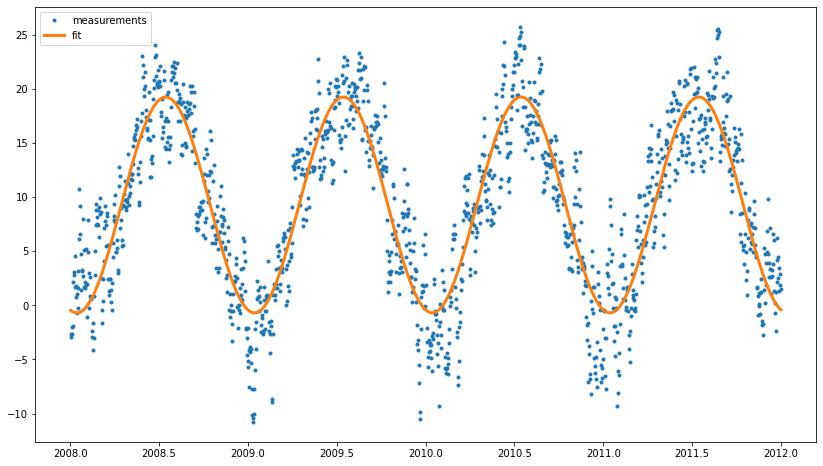

In [152]:
def func(t, a, b, c):
  return a*np.cos(2*np.pi*t + b) + c

restricted_df = df[(df['times'] > 2008) & (df['times'] < 2012) & (df['values'] < 60)] # we remove absurd temperature measurements as well

popt, pcov = optimize.curve_fit(func, restricted_df['times'], restricted_df['values'])
munich_temp_fit = func(restricted_df['times'], popt[0], popt[1], popt[2])

fig, ax = plt.subplots(figsize=(14,8))

ax.plot(restricted_df['times'], restricted_df['values'], '.', label='measurements')
ax.plot(restricted_df['times'], munich_temp_fit, '-', label='fit', linewidth=3)
ax.legend()

print("The best-fit values of the parameters for function f are:")
print("a: {};\nb: {};\nc: {}.\n".format(popt[0], popt[1], popt[2]))

print("The overall average temperature in Munich between 2008 and 2012 was of {:.2f} °C.\n".format(restricted_df['values'].mean()))

years = restricted_df['times'].to_numpy().astype(int)
restricted_df.insert(2, 'years', years, True)
coldest_temp = restricted_df.groupby('years')['values'].min().mean()
hottest_temp = restricted_df.groupby('years')['values'].max().mean()

print("The model predicts the following extreme daily averages:")
print("Coldest temperature: {:.2f} °C".format(coldest_temp))
print("Hottest temperature: {:.2f} °C".format(hottest_temp))

The $b$ parameter corresponds to the phase of the sinusoidal function, thus allowing for shift in time

In [129]:
def g(t, a, b, c, d):
  return a*np.cos(2*np.pi*b*t + c) + d

popt_2, pcov_2 = optimize.curve_fit(g, restricted_df['times'], restricted_df['values'])
munich_temp_fit_2 = g(restricted_df['times'], popt_2[0], popt_2[1], popt_2[2], popt_2[3])
print("The best-fit values of the parameters for function g are:")
print("a: {};\nb: {};\nc: {};\nd: {}.\n".format(popt_2[0], popt_2[1], popt_2[2], popt_2[3]))

The best-fit values of the parameters for function g are:
a: -9.960728588469605;
b: 1.000293497981589;
c: 8.624990177037382;
d: 9.26567493445989.



In [151]:
ssr_1 = np.sum((munich_temp_fit - restricted_df['values'])**2)

ssr_2 = np.sum((munich_temp_fit_2 - restricted_df['values'])**2)

print("SSR value for f(x): {}".format(ssr_1))
print("SSR value for g(x): {}".format(ssr_2))

SSR value for f(x): 18669.515394578364
SSR value for g(x): 18669.225430956096


In [110]:
from scipy.stats import f

# define function for F-test
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

print("Ftest results:")
f_vs_g = Ftest(ssr_1, ssr_2, 3, 4, len(munich_temp), verbose=True)

Ftest results:
CL: 1.000 , additional parameter necessary: NO
